# pyPanair Tutorial#2 Tapered Wing  
In this tutorial we will perform an analysis of a tapered wing.  
The wing is defined by five different wing sections at $\eta=0.000, 0.126, 0.400, 0.700, 1.000$.  

Below are the wing planform and airfoil stack, respectively.
(The wing is based on the [DLR-F4<sup>1</sup>](https://aiaa-dpw.larc.nasa.gov/Workshop1/files/agard-ar-303.pdf))

![planform](planform.png)

<IPython.core.display.Javascript object>


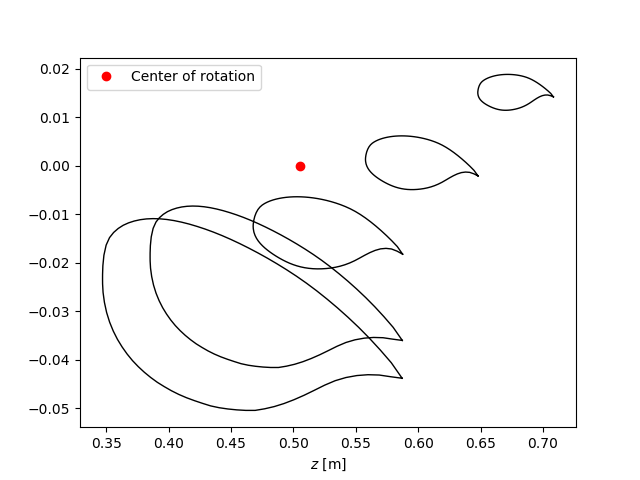

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from pyPanair.preprocess import wgs_creator
for eta in ("0000", "0126", "0400", "0700", "1000"):
    af = wgs_creator.read_airfoil("eta{}.csv".format(eta)) 
    plt.plot(af[:,0], af[:,2], "k-", lw=1.)
plt.plot((0.5049,), (0,), "ro", label="Center of rotation")
plt.legend(loc="best")
plt.xlabel("$x$ [m]")
plt.xlabel("$z$ [m]")
plt.show()

## 1.Defining the geometry
Just as we have done in tutorial 1, we will use the `wgs_creator` module to define the geometry of the wing.

First off, we initialize a `LaWGS` object.

In [2]:
from pyPanair.preprocess import wgs_creator
wgs = wgs_creator.LaWGS("tapered_wing")

Next, we create a `Line` object that defines the coordinates of the airfoil at the root of the wing.  
To do so, we will read a csv file that contains the coordinates of the airfoil, using the `read_airfoil` function.  

Five csv files, `eta0000.csv`, `eta0126.csv`, `eta0400.csv`, `eta0700.csv`, and `eta1000.csv` have been prepared for this tutorial.  

Before creating the `Line` object, we will take a quick view at these files.
For example, `eta0000.csv` looks like ...

In [3]:
import pandas as pd
pd.set_option("display.max_rows", 10)
pd.read_csv("eta0000.csv")

,xup,zup,xlow,zlow
0,0.347000,-0.023367,0.347000,-0.023367
1,0.347018,-0.022381,0.347035,-0.024348
2,0.347256,-0.020599,0.347417,-0.026096
3,0.348095,-0.018430,0.348499,-0.028143
4,0.349882,-0.016352,0.350274,-0.030245
...,...,...,...,...
36,0.552256,-0.033298,0.550842,-0.043232
37,0.560901,-0.035545,0.559736,-0.043060
38,0.569621,-0.037978,0.568753,-0.043126
39,0.578415,-0.040590,0.577882,-0.043474


The first and second columns `xup` and `zup` represent the xz-coordinates of the upper surface of the airfoil.  
The third and fourth columns `xlow` and `zlow` represent the xz-coordinates of the lower surface of the airfoil.  

The csv file must follow four rules:  
1. Data in the first row correspond to the xz-coordinates of the leading edge of the airfoil  
2. Data in the last row correspond to the xz-coordinates of the trailing edge of the airfoil  
3. For the first row, the coordinates `(xup, zup)` and `(xlow, zlow)` are the same  
4. For the last row, the coordinates `(xup, zup)` and `(xlow, zlow)` are the same (i.e. the airfoil has a sharp TE)  

Now we shall create a `Line` object for the root of the wing.

In [4]:
wingsection1 = wgs_creator.read_airfoil("eta0000.csv", y_coordinate=0.)

The first variable specifies the name of the csv file.  
The `y_coordinate` variable defines the y-coordinate of the points included in the `Line`.

`Line` objects for the remaining four wing sections can be created in the same way.

In [5]:
wingsection2 = wgs_creator.read_airfoil("eta0126.csv", y_coordinate=0.074211)
wingsection3 = wgs_creator.read_airfoil("eta0400.csv", y_coordinate=0.235051)
wingsection4 = wgs_creator.read_airfoil("eta0700.csv", y_coordinate=0.410350)
wingsection5 = wgs_creator.read_airfoil("eta1000.csv", y_coordinate=0.585650)

Next, we create four networks by linearly interpolating these wing sections.

In [6]:
wingnet1 = wingsection1.linspace(wingsection2, num=4)
wingnet2 = wingsection2.linspace(wingsection3, num=8)
wingnet3 = wingsection3.linspace(wingsection4, num=9)
wingnet4 = wingsection4.linspace(wingsection5, num=9)

Then, we concatenate the networks using the `concat_row` method.

In [7]:
wing = wingnet1.concat_row((wingnet2, wingnet3, wingnet4))

The concatenated network is displayed below.

<IPython.core.display.Javascript object>


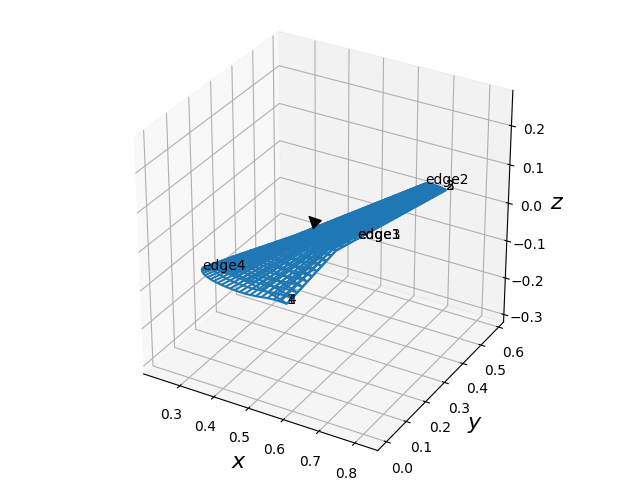

In [8]:
wing.plot_wireframe()

After creating the `Network` for the wing, we create networks for the wingtip and wake.

In [9]:
wingtip_up, wingtip_low = wingsection5.split_half()
wingtip_low = wingtip_low.flip()
wingtip = wingtip_up.linspace(wingtip_low, num=5)

In [10]:
wake_length = 50 * 0.1412
wingwake = wing.make_wake(edge_number=3, wake_length=wake_length)

Next, the `Networks` will be registered to the `wgs` object.


In [11]:
wgs.append_network("wing", wing, 1)
wgs.append_network("wingtip", wingtip, 1)
wgs.append_network("wingwake", wingwake, 18)

Then, we create a stl file to check that there are no errors in the model.  


In [12]:
wgs.create_stl()

Last, we create input files for `panin`


In [13]:
wgs.create_aux(alpha=(-2, 0, 2), mach=0.6, cbar=0.1412, span=1.1714, sref=0.1454, xref=0.5049, zref=0.)
wgs.create_wgs()

## 2. Analysis

The analysis can be done in the same way as tutorial 1.  
Place `panair`, `panin`, `tapered_wing.aux`, and `tapered_wing.wgs` in the same directory, 
and run `panin` and `panair`.

```bash
$ ./panin
 Prepare input for PanAir
  Version 1.0 (4Jan2000)
 Ralph L. Carmichael, Public Domain Aeronautical Software
 Enter the name of the auxiliary file: 
tapered_wing.aux
          10  records copied from auxiliary file.
           9  records in the internal data file.
  Geometry data to be read from tapered_wing.wgs                                                                
 Reading WGS file...
 Reading network wing
 Reading network wingtip
 Reading network wingwake
 Reading input file instructions...
 Command  1 MACH 0.6
 Command 11 ALPHA -2 0 2
 Command  6 cbar 0.1412
 Command  7 span 1.1714
 Command  2 sref 0.1454
 Command  3 xref 0.5049
 Command  5 zref 0.0
 Command 35 BOUN 1 1 18
 Writing PanAir input file...
  Files a502.in added to your directory.
 Also, file panin.dbg
 Normal termination of panin, version 1.0 (4Jan2000)
 Normal termination of panin
```

```bash
$ ./panair
 Panair High Order Panel Code, Version 15.0 (10 December 2009)
 Enter name of input file:
a502.in
```

After the analysis finishes, place `panair.out`, `agps`, and `ffmf` in the `tutorial2` directory.

## 3. Visualization

Visualization of the results can be done in the same manner as tutorial 2.

In [14]:
from pyPanair.postprocess import write_vtk
write_vtk(n_wake=1)

n_wake =  1
network 1 shape:  (27, 81, 7)
network 2 shape:  (5, 41, 7)


In [15]:
from pyPanair.postprocess import calc_section_force
calc_section_force(aoa=2, mac=0.1412, rot_center=(0.5049,0,0), casenum=3, networknum=1)

<IPython.core.display.Javascript object>


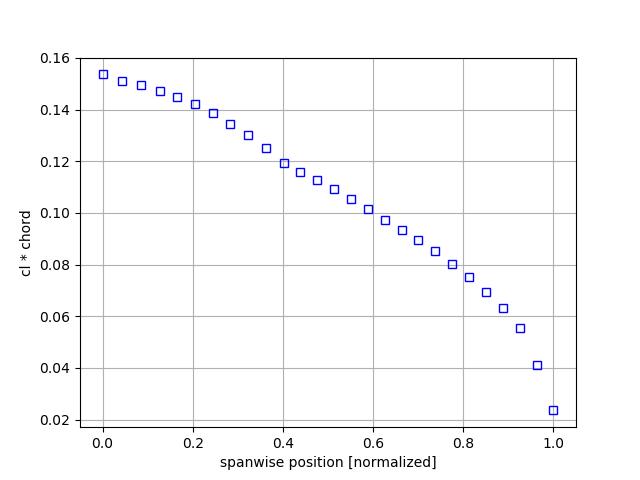

In [16]:
section_force = pd.read_csv("section_force.csv")
section_force

plt.plot(section_force.pos / 0.5857, section_force.cl * section_force.chord, "s", mfc="None", mec="b")
plt.xlabel("spanwise position [normalized]")
plt.ylabel("cl * chord")
plt.grid()
plt.show()

The `ffmf` file can be parsed using the `read_ffmf` and `write_ffmf` methods.


In [17]:
from pyPanair.postprocess import write_ffmf, read_ffmf
read_ffmf()

,sol-no,alpha,beta,cl,cdi,cy,fx,fy,fz,mx,my,mz,area
0,1,-2.0000,0.0000,0.46108,0.00737,-0.00000,0.02346,-0.00000,0.46054,0.00000,-0.10788,-0.00000,0.30720
1,2,0.0000,0.0000,0.66555,0.01538,-0.00000,0.01538,-0.00000,0.66555,0.00000,-0.11753,-0.00000,0.30720
2,3,2.0000,0.0000,0.86890,0.02630,-0.00000,-0.00404,-0.00000,0.86929,0.00000,-0.12618,0.00000,0.30720


In [18]:
write_ffmf()

The `read_ffmf` method parses the `ffmf` file and converts it to a `pandas` `DataFrame`.  
The `write_ffmf` will convert the `ffmf` file to a csv file. (The default name of the converted file is `ffmf.csv`)

This is the end of tutorial 2.

### Reference
1. Redeker, G., "A selection of experimental test cases for the validation of CFD codes,"
 *AGARD AR-303*, 1994.